# Custom Activation Functions #
While training neural networks, it is common practice to use well defined, functions like sigmoid, relu, tanh and others.

Given that we already tested softmax, we can implement a custom activation function as well and compare its performance to the following
* Sigmoid
* Softmax
* Leaky ReLU

## First, we will implement the basic neural network architecture ##
 ### 1. Library Imports ###

In [1]:
import numpy as np                         # For Array Operations
import pandas as pd                        # For DataFrame Operations
import matplotlib.pyplot as plt            # For Plotting
import struct                              # For Binary Data Conversion (MNIST Dataset)

### Custom Activation Function (sinlog) ###
Define a piecewise activation function f(x) named 'sinlog' such that:
$$
f(x) =
\begin{cases} 
\sin(x) & \text{if } x < 0 \\
\log(1+x) & \text{if } x \geq 0
\end{cases}
$$


In [2]:
# Defining the activation functions and their derivatives
def activation_function(function_name):
    try:                                                                  
        if function_name.lower() == 'sigmoid':
            return lambda x: 1 / (1 + np.exp(-x))
        elif function_name.lower() == 'tanh':
            return lambda x: np.tanh(x)
        elif function_name.lower() == 'relu':
            return lambda x: np.maximum(0, x)   
        elif function_name.lower() == 'leaky_relu':
            return lambda x: np.where(x > 0, x, 0.01 * x)
        elif function_name.lower() == 'softmax':
            return lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)
        elif function_name.lower() == 'sinlog':                                 # Custom function definition using np.where
            return lambda x: np.where(x < 0, np.sin(x), np.log(x + 1))
    except Exception as e:
        print(f"Error finding activation function: {e}")
        return None
        
def activation_derivative(function_name):
    try:
        if function_name.lower() == 'sigmoid':
            return lambda x: x * (1 - x)
        elif function_name.lower() == 'tanh':
            return lambda x: 1 - np.tanh(x) ** 2
        elif function_name.lower() == 'relu':
            return lambda x: np.where(x > 0, 1, 0)
        elif function_name.lower() == 'leaky_relu':
            return lambda x: np.where(x > 0, 1, 0.01)
        elif function_name.lower() == 'softmax':
            return lambda x: x * (1 - x)
        elif function_name.lower() == 'sinlog':                               # Custom function derivative definition using np.where
            return lambda x: np.where(x < 0, np.cos(x), 1 / (x + 1))
    except Exception as e:
        print(f"Error finding activation derivative function: {e}")
        return None
    
    
# Defining the loss functions and their derivatives      
def loss_function(function_name):
    try:
        if (function_name.lower() == 'mean_squared_error'):
            return lambda y_true, y_pred: np.mean((y_true - y_pred) ** 2)
        elif (function_name.lower() == 'binary_crossentropy'):
            return lambda y_true, y_pred: -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        elif (function_name.lower() == 'categorical_crossentropy'):
            return lambda y_true, y_pred: -np.sum(y_true * np.log(y_pred + 1e-5), axis=1).mean()
    except Exception as e:
        print(f"Error finding loss function: {e}")
        return None

def loss_derivative(function_name):
    try:
        if (function_name.lower() == 'mean_squared_error'):
            return lambda y_true, y_pred: 2 * (y_pred - y_true) / y_true.size
        elif (function_name.lower() == 'binary_crossentropy'):
            return lambda y_true, y_pred: -(y_true / y_pred) + ((1 - y_true) / (1 - y_pred))
        elif (function_name.lower() == 'categorical_crossentropy'):
            return lambda y_true, y_pred: y_pred - y_true
    except Exception as e:
        print(f"Error finding loss derivative function: {e}")
        return None

## Layer Class ##


In [3]:
class Layer:
    # Initializing the layer with weights and biases with a default activation function (Sigmoid)
    def __init__(self, input_size, output_size, function_name='sigmoid'):
        self.W = np.random.randn(output_size, input_size) * 0.01    # Initializing weights with small random values
        self.B = np.zeros((output_size, 1))                         # Initializing biases with zeros
        self.function_name = function_name                          # Storing the activation function name
        
    # Defining the feed forward function for the layer
    def feed_forward(self, X):
        self.input = X                                              # Storing the input for back propagation
        self.Z = np.dot(self.W, X) + self.B                         # Simply implementing the formula Z = WX + B
        self.A = activation_function(self.function_name)(self.Z)    # Applying the activation function to Z to get A
        return self.A
    
    # Defining the back propagation function for the layer
    def back_propagation(self, dA):
        m = self.input.shape[1]                                     # To utilise batch processing (Averaging over m samples per batch)
        dL = dA * activation_derivative(self.function_name)(self.A) # Using the chain rule to calculate the derivative of the loss with respect to Z - (dL = dL/dZ)
        self.dW = np.dot(dL, self.input.T) / m                      # Gradient of the loss with respect to W - (dL/dW = dL/dZ * dZ/dW)
        self.dB = np.sum(dL, axis=1, keepdims=True) / m             # Gradient of the loss with respect to B - (dL/dB = dL/dZ * dZ/dB)
        dX = np.dot(self.W.T, dL)                                   # Gradient of the loss with respect to Input - (dL/dX = dL/dZ * dZ/dX)          
        
        return dX                                                   # Return the gradient of the loss with respect to the input for the next layer

## Data Loader ##

In [4]:
# Image Loader
def load_idx_images(filename):
    
    with open(filename, 'rb') as f:
        # The first 4 bytes contain the magic number
        magic = struct.unpack('>I', f.read(4))[0]
        # The next 4 bytes contain the number of images
        num_images = struct.unpack('>I', f.read(4))[0]
        # Next, number of rows and columns
        num_rows = struct.unpack('>I', f.read(4))[0]
        num_cols = struct.unpack('>I', f.read(4))[0]
        # Read the rest of the data:
        # Each pixel is stored as an unsigned byte.
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, num_rows*num_cols)
    return images

# Label Loader
def load_idx_labels(filename):
    
    with open(filename, 'rb') as f:
        magic = struct.unpack('>I', f.read(4))[0]
        num_labels = struct.unpack('>I', f.read(4))[0]
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


-> Loading the MNIST Dataset

In [5]:
images = load_idx_images(r'D:\Coding\DSGxRMS\Artificial Neural Network\Dataset\train-images.idx3-ubyte').astype('float64') / 255.0  # Load the MNIST training images
labels = load_idx_labels(r'D:\Coding\DSGxRMS\Artificial Neural Network\Dataset\train-labels.idx1-ubyte')  # Load the MNIST training labels

# Creating the Dataframe
df = pd.DataFrame(images)  # Create a DataFrame from the images
df['label'] = labels  # Add the labels to the DataFrame

print(df.head())  # Print the first 5 rows of the DataFrame
print(df.shape)  # Print the shape of the DataFrame
print(df.describe())

     0    1    2    3    4    5    6    7    8    9  ...  775  776  777  778  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   779  780  781  782  783  label  
0  0.0  0.0  0.0  0.0  0.0      5  
1  0.0  0.0  0.0  0.0  0.0      0  
2  0.0  0.0  0.0  0.0  0.0      4  
3  0.0  0.0  0.0  0.0  0.0      1  
4  0.0  0.0  0.0  0.0  0.0      9  

[5 rows x 785 columns]
(60000, 785)
             0        1        2        3        4        5        6        7  \
count  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0

# Defining multiple Neural Network Architectures #


### 1. Sinlog Neural Network ###
Here, we will keep the output layer's activation function as a different activation function while hidden layers will be kept as ReLU/ Leaky ReLU for relatively comparative performance metric in all 4 cases of testing

In [ ]:
class SinLog_NeuralNetwork:
    def __init__(self, epochs = 100, batch_size = 64, learning_rate = 0.1):
        
        # Initializing the neural network with a list of layers
        
        self.layers= []                      # List to store the layers of the neural network
        Layer1 = Layer(784, 512, 'relu')     # Input layer with 784 input neurons and 512 output neurons
        Layer2 = Layer(512, 256, 'relu')     # Hidden layer with 512 input neurons and 256 output neurons
        Layer3 = Layer(256, 128, 'relu')     # Hidden layer with 256 input neurons and 128 output neurons
        Layer4 = Layer(128, 10, 'sinlog')    # Output layer with 128 input neurons and 10 output neurons (for 10 classes)
        
        # Append the layers to the list
        self.layers.append(Layer1)  
        self.layers.append(Layer2)
        self.layers.append(Layer3)
        self.layers.append(Layer4)
        
        self.losses = []                     # List to store the loss values during training
        self.batch_size = batch_size         # Default batch size for training
        self.epochs = epochs                 # Default number of epochs for training
        self.learning_rate = learning_rate   # Default learning rate for training
        
        
    def batch_generator(self, df):
        # Function to generate batches of data from the DataFrame
        for idx in range(0, len(df), self.batch_size):
            yield df.iloc[idx : idx + self.batch_size]
    
    def process_batch(self, batch_df):
        # Function to process a batch of data
        X_batch = batch_df.iloc[:, :784].values             # Shape (batch_size, 784)
        X_batch = X_batch.T                                 # Transpose to match the input shape (784, batch_size)
        
        labels = batch_df['label'].values                   # Shape (batch_size,)
        
        # Encoding the labels
        num_classes = 10
        num_examples = len(labels)
        Y_batch = np.zeros((num_examples, num_classes))
        
        for i, label in enumerate(labels):
            Y_batch[i, label] = 1
            
        Y_batch = Y_batch.T                      # Transpose to shape (10, batch_size)
        
        return X_batch, Y_batch


    def train(self, df):
        # Training the neural network on the given DataFrame
        
        for epoch in range(1, self.epochs + 1):
            loss = 0
            batch_number = 0
            
            for batch_df in self.batch_generator(df):
                X_batch, Y_batch = self.process_batch(batch_df)  # Process the batch of data
                
                A = X_batch
                
                for layer in self.layers:
                    A = layer.feed_forward(A)
                
                output = A

                loss += np.mean(loss_function('categorical_crossentropy')(Y_batch, output))  # Calculate the loss value using categorical crossentropy
                batch_number += 1
                dA = loss_derivative('categorical_crossentropy')(Y_batch, output)
                
                for layer in reversed(self.layers):
                    dA = layer.back_propagation(dA)
                    
                for layer in self.layers:
                    layer.W -= self.learning_rate * layer.dW  # Update the weights of the layer
                    layer.B -= self.learning_rate * layer.dB  # Update the biases of the layer
                
            # Average loss over the batches
            loss /= batch_number
            self.losses.append(loss)                          # Append the loss value to the list of losses
            
            if epoch % 10 == 0:                                 # Print the loss value every 10 epochs
                print(f"Epoch {epoch}/{self.epochs}, Loss: {loss:.5f}")
            
        plt.plot(range(1, len(self.losses) + 1), self.losses)   # Plot the loss values
        plt.title('Loss Value vs Epochs')                       # Set the title of the plot
        plt.xlabel('Epochs')                                    # Set the x-axis label
        plt.ylabel('Loss Value')                                # Set the y-axis label
        plt.grid()                                              # Add grid lines to the plot
        plt.show()                                              # Show the plot
    
    def predict(self, df):
        # Function to make predictions on the given DataFrame
        X_batch = df.iloc[:, :784].values
        X_batch = X_batch.T          
        
        
        A = X_batch
        
        for layer in self.layers:
            A = layer.feed_forward(A)
            
        predictions = np.argmax(A, axis=0)            # Get the index of the maximum value in each column (predicted class)
        return predictions            
            

### 2. Sigmoid Neural Network ###

In [7]:
class Sigmoid_NeuralNetwork:
    def __init__(self, epochs = 100, batch_size = 64, learning_rate = 0.1):
        
        # Initializing the neural network with a list of layers
        
        self.layers= []                      # List to store the layers of the neural network
        Layer1 = Layer(784, 512, 'relu')     # Input layer with 784 input neurons and 512 output neurons
        Layer2 = Layer(512, 256, 'relu')     # Hidden layer with 512 input neurons and 256 output neurons
        Layer3 = Layer(256, 128, 'relu')     # Hidden layer with 256 input neurons and 128 output neurons
        Layer4 = Layer(128, 10, 'sigmoid')   # Output layer with 128 input neurons and 10 output neurons (for 10 classes)
        
        # Append the layers to the list
        self.layers.append(Layer1)  
        self.layers.append(Layer2)
        self.layers.append(Layer3)
        self.layers.append(Layer4)
        
        self.losses = []                     # List to store the loss values during training
        self.batch_size = batch_size         # Default batch size for training
        self.epochs = epochs                 # Default number of epochs for training
        self.learning_rate = learning_rate   # Default learning rate for training
        
        
    def batch_generator(self, df):
        # Function to generate batches of data from the DataFrame
        for idx in range(0, len(df), self.batch_size):
            yield df.iloc[idx : idx + self.batch_size]
    
    def process_batch(self, batch_df):
        # Function to process a batch of data
        X_batch = batch_df.iloc[:, :784].values             # Shape (batch_size, 784)
        X_batch = X_batch.T                                 # Transpose to match the input shape (784, batch_size)
        
        labels = batch_df['label'].values                   # Shape (batch_size,)
        
        # Encoding the labels
        num_classes = 10
        num_examples = len(labels)
        Y_batch = np.zeros((num_examples, num_classes))
        
        for i, label in enumerate(labels):
            Y_batch[i, label] = 1
            
        Y_batch = Y_batch.T                      # Transpose to shape (10, batch_size)
        
        return X_batch, Y_batch


    def train(self, df):
        # Training the neural network on the given DataFrame
        
        for epoch in range(1, self.epochs + 1):
            loss = 0
            batch_number = 0
            
            for batch_df in self.batch_generator(df):
                X_batch, Y_batch = self.process_batch(batch_df)  # Process the batch of data
                
                A = X_batch
                
                for layer in self.layers:
                    A = layer.feed_forward(A)
                
                output = A

                loss += np.mean(loss_function('categorical_crossentropy')(Y_batch, output))  # Calculate the loss value using categorical crossentropy
                batch_number += 1
                dA = loss_derivative('categorical_crossentropy')(Y_batch, output)
                
                for layer in reversed(self.layers):
                    dA = layer.back_propagation(dA)
                    
                for layer in self.layers:
                    layer.W -= self.learning_rate * layer.dW  # Update the weights of the layer
                    layer.B -= self.learning_rate * layer.dB  # Update the biases of the layer
                
            # Average loss over the batches
            loss /= batch_number
            self.losses.append(loss)                          # Append the loss value to the list of losses
            
            if epoch % 10 == 0:                                 # Print the loss value every 10 epochs
                print(f"Epoch {epoch}/{self.epochs}, Loss: {loss:.5f}")
            
        plt.plot(range(1, len(self.losses) + 1), self.losses)   # Plot the loss values
        plt.title('Loss Value vs Epochs')                       # Set the title of the plot
        plt.xlabel('Epochs')                                    # Set the x-axis label
        plt.ylabel('Loss Value')                                # Set the y-axis label
        plt.grid()                                              # Add grid lines to the plot
        plt.show()                                              # Show the plot
    
    def predict(self, df):
        # Function to make predictions on the given DataFrame
        X_batch = df.iloc[:, :784].values
        X_batch = X_batch.T          
        
        
        A = X_batch
        
        for layer in self.layers:
            A = layer.feed_forward(A)
            
        predictions = np.argmax(A, axis=0)            # Get the index of the maximum value in each column (predicted class)
        return predictions            
            

### 3. Leaky_ReLU Neural Network ###

In [8]:
class LeakyReLU_NeuralNetwork:
    def __init__(self, epochs = 100, batch_size = 64, learning_rate = 0.1):
        
        # Initializing the neural network with a list of layers
        
        self.layers= []                         # List to store the layers of the neural network
        Layer1 = Layer(784, 512, 'relu')        # Input layer with 784 input neurons and 512 output neurons
        Layer2 = Layer(512, 256, 'relu')        # Hidden layer with 512 input neurons and 256 output neurons
        Layer3 = Layer(256, 128, 'relu')        # Hidden layer with 256 input neurons and 128 output neurons
        Layer4 = Layer(128, 10, 'leaky_relu')    # Output layer with 128 input neurons and 10 output neurons (for 10 classes)
        
        # Append the layers to the list
        self.layers.append(Layer1)  
        self.layers.append(Layer2)
        self.layers.append(Layer3)
        self.layers.append(Layer4)
        
        self.losses = []                     # List to store the loss values during training
        self.batch_size = batch_size         # Default batch size for training
        self.epochs = epochs                 # Default number of epochs for training
        self.learning_rate = learning_rate   # Default learning rate for training
        
        
    def batch_generator(self, df):
        # Function to generate batches of data from the DataFrame
        for idx in range(0, len(df), self.batch_size):
            yield df.iloc[idx : idx + self.batch_size]
    
    def process_batch(self, batch_df):
        # Function to process a batch of data
        X_batch = batch_df.iloc[:, :784].values             # Shape (batch_size, 784)
        X_batch = X_batch.T                                 # Transpose to match the input shape (784, batch_size)
        
        labels = batch_df['label'].values                   # Shape (batch_size,)
        
        # Encoding the labels
        num_classes = 10
        num_examples = len(labels)
        Y_batch = np.zeros((num_examples, num_classes))
        
        for i, label in enumerate(labels):
            Y_batch[i, label] = 1
            
        Y_batch = Y_batch.T                      # Transpose to shape (10, batch_size)
        
        return X_batch, Y_batch


    def train(self, df):
        # Training the neural network on the given DataFrame
        
        for epoch in range(1, self.epochs + 1):
            loss = 0
            batch_number = 0
            
            for batch_df in self.batch_generator(df):
                X_batch, Y_batch = self.process_batch(batch_df)  # Process the batch of data
                
                A = X_batch
                
                for layer in self.layers:
                    A = layer.feed_forward(A)
                
                output = A

                loss += np.mean(loss_function('categorical_crossentropy')(Y_batch, output))  # Calculate the loss value using categorical crossentropy
                batch_number += 1
                dA = loss_derivative('categorical_crossentropy')(Y_batch, output)
                
                for layer in reversed(self.layers):
                    dA = layer.back_propagation(dA)
                    
                for layer in self.layers:
                    layer.W -= self.learning_rate * layer.dW  # Update the weights of the layer
                    layer.B -= self.learning_rate * layer.dB  # Update the biases of the layer
                
            # Average loss over the batches
            loss /= batch_number
            self.losses.append(loss)                          # Append the loss value to the list of losses
            
            if epoch % 10 == 0:                                 # Print the loss value every 10 epochs
                print(f"Epoch {epoch}/{self.epochs}, Loss: {loss:.5f}")
            
        plt.plot(range(1, len(self.losses) + 1), self.losses)   # Plot the loss values
        plt.title('Loss Value vs Epochs')                       # Set the title of the plot
        plt.xlabel('Epochs')                                    # Set the x-axis label
        plt.ylabel('Loss Value')                                # Set the y-axis label
        plt.grid()                                              # Add grid lines to the plot
        plt.show()                                              # Show the plot
    
    def predict(self, df):
        # Function to make predictions on the given DataFrame
        X_batch = df.iloc[:, :784].values
        X_batch = X_batch.T          
        
        
        A = X_batch
        
        for layer in self.layers:
            A = layer.feed_forward(A)
            
        predictions = np.argmax(A, axis=0)            # Get the index of the maximum value in each column (predicted class)
        return predictions            
            

### 4. Softmax Neural Network ###

In [9]:
class Softmax_NeuralNetwork:
    def __init__(self, epochs = 100, batch_size = 64, learning_rate = 0.1):
        
        # Initializing the neural network with a list of layers
        
        self.layers= []                      # List to store the layers of the neural network
        Layer1 = Layer(784, 512, 'relu')     # Input layer with 784 input neurons and 512 output neurons
        Layer2 = Layer(512, 256, 'relu')     # Hidden layer with 512 input neurons and 256 output neurons
        Layer3 = Layer(256, 128, 'relu')     # Hidden layer with 256 input neurons and 128 output neurons
        Layer4 = Layer(128, 10, 'softmax')   # Output layer with 128 input neurons and 10 output neurons (for 10 classes)
        
        # Append the layers to the list
        self.layers.append(Layer1)  
        self.layers.append(Layer2)
        self.layers.append(Layer3)
        self.layers.append(Layer4)
        
        self.losses = []                     # List to store the loss values during training
        self.batch_size = batch_size         # Default batch size for training
        self.epochs = epochs                 # Default number of epochs for training
        self.learning_rate = learning_rate   # Default learning rate for training
        
        
    def batch_generator(self, df):
        # Function to generate batches of data from the DataFrame
        for idx in range(0, len(df), self.batch_size):
            yield df.iloc[idx : idx + self.batch_size]
    
    def process_batch(self, batch_df):
        # Function to process a batch of data
        X_batch = batch_df.iloc[:, :784].values             # Shape (batch_size, 784)
        X_batch = X_batch.T                                 # Transpose to match the input shape (784, batch_size)
        
        labels = batch_df['label'].values                   # Shape (batch_size,)
        
        # Encoding the labels
        num_classes = 10
        num_examples = len(labels)
        Y_batch = np.zeros((num_examples, num_classes))
        
        for i, label in enumerate(labels):
            Y_batch[i, label] = 1
            
        Y_batch = Y_batch.T                      # Transpose to shape (10, batch_size)
        
        return X_batch, Y_batch


    def train(self, df):
        # Training the neural network on the given DataFrame
        
        for epoch in range(1, self.epochs + 1):
            loss = 0
            batch_number = 0
            
            for batch_df in self.batch_generator(df):
                X_batch, Y_batch = self.process_batch(batch_df)  # Process the batch of data
                
                A = X_batch
                
                for layer in self.layers:
                    A = layer.feed_forward(A)
                
                output = A
                
                loss += np.mean(loss_function('categorical_crossentropy')(Y_batch, output))  # Calculate the loss value using categorical crossentropy
                batch_number += 1
                dA = loss_derivative('categorical_crossentropy')(Y_batch, output)
                
                for layer in reversed(self.layers):
                    dA = layer.back_propagation(dA)
                    
                for layer in self.layers:
                    layer.W -= self.learning_rate * layer.dW  # Update the weights of the layer
                    layer.B -= self.learning_rate * layer.dB  # Update the biases of the layer
                
            # Average loss over the batches
            loss /= batch_number
            self.losses.append(loss)                          # Append the loss value to the list of losses
            
            if epoch % 10 == 0:                                 # Print the loss value every 10 epochs
                print(f"Epoch {epoch}/{self.epochs}, Loss: {loss:.5f}")
            
        plt.plot(range(1, len(self.losses) + 1), self.losses)   # Plot the loss values
        plt.title('Loss Value vs Epochs')                       # Set the title of the plot
        plt.xlabel('Epochs')                                    # Set the x-axis label
        plt.ylabel('Loss Value')                                # Set the y-axis label
        plt.grid()                                              # Add grid lines to the plot
        plt.show()                                              # Show the plot
    
    def predict(self, df):
        # Function to make predictions on the given DataFrame
        X_batch = df.iloc[:, :784].values
        X_batch = X_batch.T          
        
        
        A = X_batch
        
        for layer in self.layers:
            A = layer.feed_forward(A)
            
        predictions = np.argmax(A, axis=0)            # Get the index of the maximum value in each column (predicted class)
        return predictions            
            

## Training the Models ##

C:\Users\armaa\AppData\Local\Temp\ipykernel_8784\76362249.py:47: RuntimeWarning: invalid value encountered in log
  return lambda y_true, y_pred: -np.sum(y_true * np.log(y_pred + 1e-5), axis=1).mean()


Epoch 10/100, Loss: 29.70764
Epoch 20/100, Loss: 29.43589
Epoch 30/100, Loss: 29.42699
Epoch 40/100, Loss: 29.42355
Epoch 50/100, Loss: 29.41991
Epoch 60/100, Loss: 29.41551
Epoch 70/100, Loss: 29.41020
Epoch 80/100, Loss: 29.40384
Epoch 90/100, Loss: 29.39614
Epoch 100/100, Loss: 29.38655


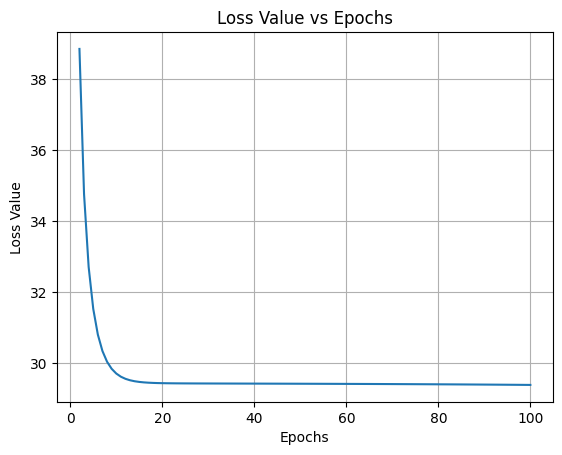

SinLog Neural Network Training Completed


In [11]:
# SinLog Neural Network Training
sinlognn = SinLog_NeuralNetwork(epochs=100, batch_size=128, learning_rate=0.001)  # Create an instance of the SinLog_NeuralNetwork class
sinlognn.train(df)                                                             # Train the neural network on the DataFrame
print("SinLog Neural Network Training Completed")                              # Print a message indicating that the training is completed

Epoch 10/100, Loss: 4.46654
Epoch 20/100, Loss: 1.19696
Epoch 30/100, Loss: 0.71815
Epoch 40/100, Loss: 0.55033
Epoch 50/100, Loss: 0.47764
Epoch 60/100, Loss: 0.43124
Epoch 70/100, Loss: 0.40163
Epoch 80/100, Loss: 0.38420
Epoch 90/100, Loss: 0.36945
Epoch 100/100, Loss: 0.36042


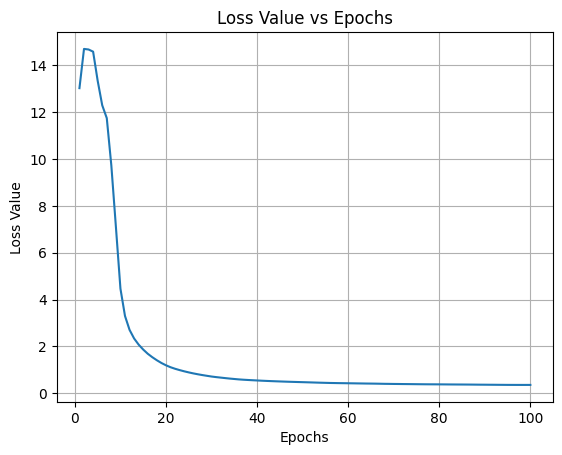

Sigmoid Neural Network Training Completed


In [12]:
# Sigmoid Neural Network Training
sigmoidnn = Sigmoid_NeuralNetwork(epochs=100, batch_size=64, learning_rate=0.1)  # Create an instance of the Sigmoid_NeuralNetwork class
sigmoidnn.train(df)                                                              # Train the neural network on the DataFrame
print("Sigmoid Neural Network Training Completed")                               # Print a message indicating that the training is completed


Epoch 10/100, Loss: 29.58044
Epoch 20/100, Loss: 29.42808
Epoch 30/100, Loss: 29.42086
Epoch 40/100, Loss: 29.41479
Epoch 50/100, Loss: 29.40770
Epoch 60/100, Loss: 29.39933
Epoch 70/100, Loss: 29.38926
Epoch 80/100, Loss: 29.37695
Epoch 90/100, Loss: 29.36143
Epoch 100/100, Loss: 29.34124


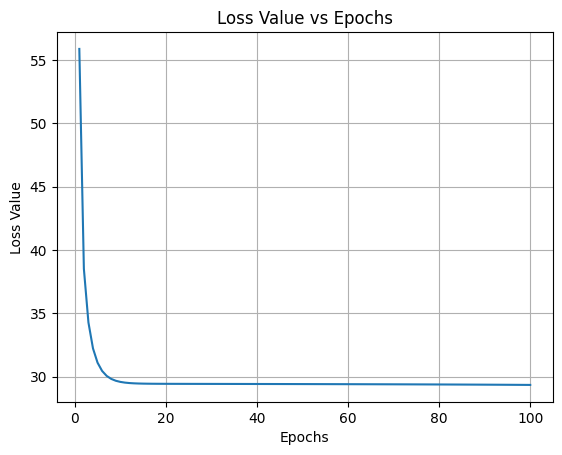

Leaky ReLU Neural Network Training Completed


In [14]:
# Leaky ReLU Neural Network Training
leakyrelunn = LeakyReLU_NeuralNetwork(epochs=100, batch_size=128, learning_rate=0.001)  # Create an instance of the LeakyReLU_NeuralNetwork class
leakyrelunn.train(df)                                                                # Train the neural network on the DataFrame   
print("Leaky ReLU Neural Network Training Completed")                                # Print a message indicating that the training is completed


Epoch 10/100, Loss: 29.42833
Epoch 20/100, Loss: 22.03605
Epoch 30/100, Loss: 3.52309
Epoch 40/100, Loss: 1.95599
Epoch 50/100, Loss: 1.30862
Epoch 60/100, Loss: 0.91400
Epoch 70/100, Loss: 0.66491
Epoch 80/100, Loss: 0.50560
Epoch 90/100, Loss: 0.41494
Epoch 100/100, Loss: 0.35860


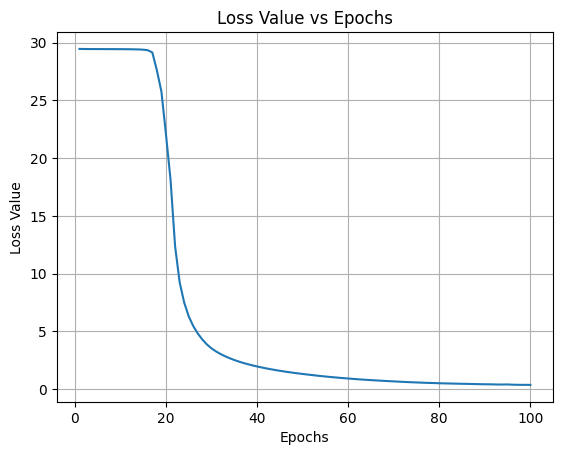

Softmax Neural Network Training Completed


In [16]:
# Softmax Neural Network Training
softmaxnn = Softmax_NeuralNetwork(epochs=100, batch_size=128, learning_rate=0.1)  # Create an instance of the Softmax_NeuralNetwork class
softmaxnn.train(df)                                                              # Train the neural network on the DataFrame
print("Softmax Neural Network Training Completed")                               # Print a message indicating that the training is completed

## Testing the models ##


In [36]:
# Load the MNIST dataset for testing:
images = load_idx_images(r'D:\Coding\DSGxRMS\Artificial Neural Network\Dataset\t10k-images.idx3-ubyte').astype('float64') / 255.0
labels = load_idx_labels(r'D:\Coding\DSGxRMS\Artificial Neural Network\Dataset\t10k-labels.idx1-ubyte')

# Create DataFrames from the images and labels:
df = pd.DataFrame(images)
df_labels = pd.DataFrame(labels)

# --------------------------
# SinLog Neural Network Prediction
# --------------------------
sinlog_prediction = sinlognn.predict(df)

correct_count = 0
total_samples = len(df_labels)

# Use enumerate to iterate over each sample correctly.
for i, row in enumerate(df_labels.iloc[:].values):
    if row[0] == sinlog_prediction[i]:
        correct_count += 1
        
sinlog_accuracy = (correct_count / total_samples) * 100
print(f"\nSinLog Accuracy: {sinlog_accuracy:.2f}%")

# --------------------------
# Sigmoid Neural Network Prediction
# --------------------------
sigmoid_prediction = sigmoidnn.predict(df)

correct_count = 0
total_samples = len(df_labels)

for i, row in enumerate(df_labels.iloc[:].values):
    if row[0] == sigmoid_prediction[i]:
        correct_count += 1
        
sigmoid_accuracy = (correct_count / total_samples) * 100
print(f"\nSigmoid Accuracy: {sigmoid_accuracy:.2f}%")

# --------------------------
# Leaky ReLU Neural Network Prediction
# --------------------------
leakyrelu_prediction = leakyrelunn.predict(df)

correct_count = 0
total_samples = len(df_labels)

for i, row in enumerate(df_labels.iloc[:].values):
    if row[0] == leakyrelu_prediction[i]:
        correct_count += 1
        
lrelu_accuracy = (correct_count / total_samples) * 100
print(f"\nLeaky ReLU Accuracy: {lrelu_accuracy:.2f}%")

# --------------------------
# Softmax Neural Network Prediction
# --------------------------
softmax_prediction = softmaxnn.predict(df)

correct_count = 0
total_samples = len(df_labels)

for i, row in enumerate(df_labels.iloc[:].values):
    if row[0] == softmax_prediction[i]:
        correct_count += 1
        
softmax_accuracy = (correct_count / total_samples) * 100
print(f"\nSoftmax Accuracy: {softmax_accuracy:.2f}%")



SinLog Accuracy: 11.35%

Sigmoid Accuracy: 97.47%

Leaky ReLU Accuracy: 11.35%

Softmax Accuracy: 96.12%


## Conclusion ##
It appears that functions like Sigmoid and Softmax perform relatively a lot better on the test set as compared to both the custom function and Leaky ReLU. The difference may be attributed to the converging tendencies of exponential functions like softmax and sigmoid and hence the results

# End Of Code #
